In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader, random_split

import matplotlib.pyplot as plt

from model import Model
from plot import plot_clusters
from utils import decay_lr, make_pinwheel_data

In [2]:
batch_dim = 50
num_clusters = 5 
num_data_per_cluster = 300

data, labels = make_pinwheel_data(0.3, 0.05, num_clusters, num_data_per_cluster, 0.25)
dataset = TensorDataset(data, labels)

train_dataset, test_dataset = random_split(dataset, [1400, 100])
train_loader = DataLoader(train_dataset, batch_size=batch_dim)
test_loader = DataLoader(test_dataset, batch_size=batch_dim)

In [3]:
num_components = 20
num_samples = 10 
latent_dim = 4 
obs_dim = 2

encoder_layers = [(obs_dim, 50), (50, 50), (50, latent_dim )]
decoder_layers = [(latent_dim, 50), (50, 50), (50, obs_dim)]
model = Model(num_components, latent_dim, obs_dim, batch_dim, num_samples, encoder_layers, decoder_layers)
theta = model.init_posterior(num_components, latent_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [4]:
num_epochs = 200
lrcvi = 0.1
global_step = 1

for epoch in range(num_epochs):

    for i, (batch_data, _) in enumerate(train_loader):

        (y_hat, x_k_samples, x_samples, log_z_given_y, phi_tilde) = model(batch_data)
        elbo = model.elbo(batch_data, y_hat, theta, phi_tilde, x_k_samples, log_z_given_y)

        with torch.no_grad():
            theta = model.m_step(theta, x_samples, torch.exp(log_z_given_y), lrcvi)

        lrcvi = decay_lr(lrcvi, global_step)

        global_step = global_step + 1
        elbo.backward()
        optimizer.step()
        model.zero_grad()

    if epoch % 50 == 0:
        neg_normed_elbo = elbo.item() / len(batch_data)
        print(f"Epoch: {epoch} {neg_normed_elbo:.6f}")

Epoch: 0 7.968185


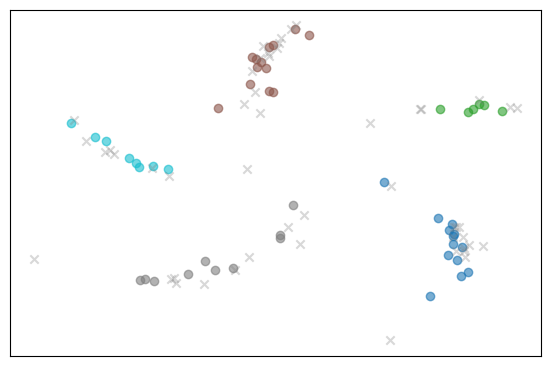

In [5]:
model.eval()
test_data, _ = next(iter(test_loader))
y_hat, _, _, log_z_given_y, _ = model(test_data)

B, D = test_data.shape
cluster_idx = torch.max(log_z_given_y, dim=1)[1].reshape(-1, 1)
n_idx = torch.arange(0, B).reshape(-1, 1).to(torch.int64)
s_idx = torch.zeros(B).reshape(-1, 1).to(torch.int64) 

y_mean = y_hat[0]
y_mean = y_mean[[n_idx, cluster_idx, s_idx]].squeeze(1)

y_mean = y_mean.detach().numpy()
original_data = test_data.detach().numpy()
cluster_idx = cluster_idx.detach().numpy()

plot_clusters(test_data, y_mean, cluster_idx.squeeze())